## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

### Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [51]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

#used this function for testing
def draw_chessboard_corners():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')
    
    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            cv2.imshow("img", img)
            cv2.waitKey(500)
    cv2.destroyAllWindows()


def calibration_mtx():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')
    
    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    
    res, mtx, dist, _, _ = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)
    return res, mtx, dist

In [52]:
# Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
res, mtx, dist = calibration_mtx()

# Store coefficients in order to use it from other notebooks
import pickle

data = {
    'mtx': mtx,
    'dist': dist
}

with open('calibration.pickle', 'wb') as f:
    pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)

def undistort_image(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

### Apply a distortion correction to raw images.

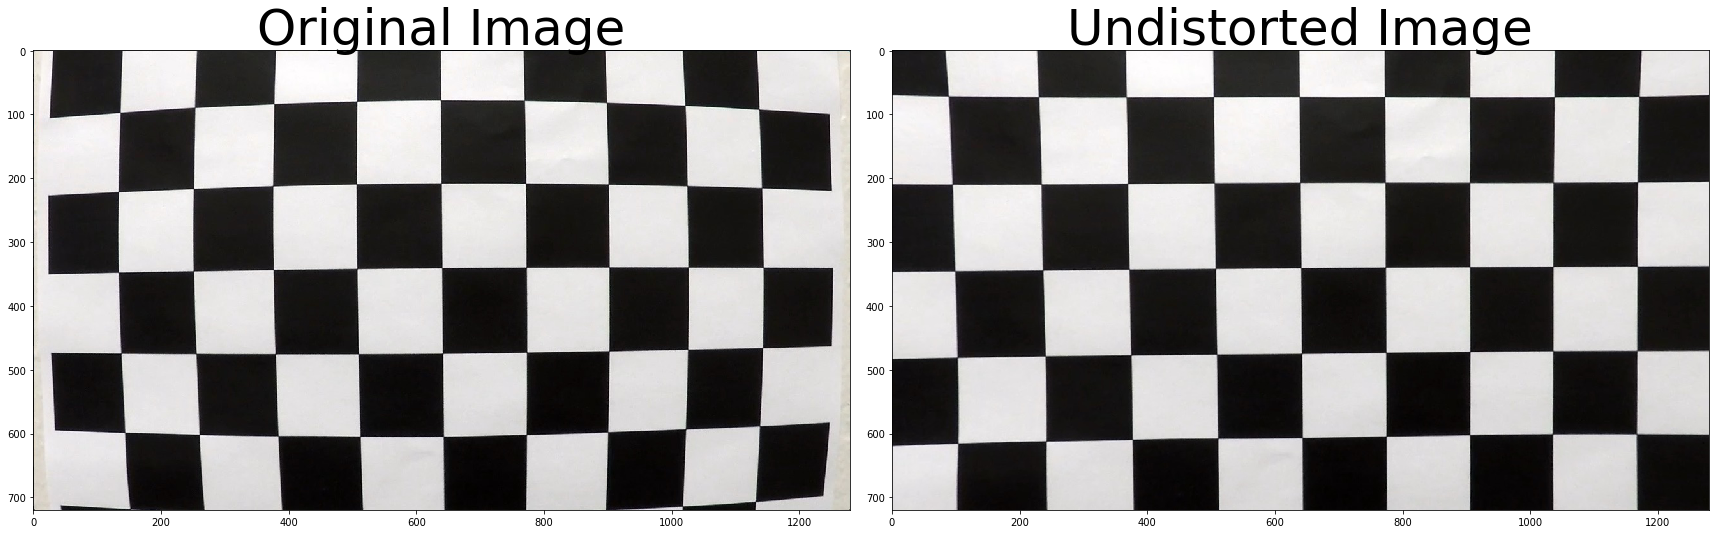

In [53]:
img = mpimg.imread('camera_cal/calibration1.jpg')

undistorted = undistort_image(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
f.show()

### Use color transforms, gradients, etc., to create a thresholded binary image.

In [54]:
def abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    
    grad_binary = np.zeros_like(scaled_sobel)
    
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
        
    return grad_binary


def apply_gradient_and_threshold(img, v_thresh=(220, 255), sx_thresh=(50, 100), dir_thresh=(0.7, 1.3)):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float)
    v_channel = hsv[:,:,2]
    s_channel = hsv[:,:,1]
    
    binary = np.zeros_like(v_channel, dtype = "uint8")
    binary [
        ((v_channel >= v_thresh[0]) & (v_channel <= v_thresh[1]))
    ] = 1

    x_s_thresh = abs_sobel_thresh(s_channel, thresh=sx_thresh)
    x_v_thresh = abs_sobel_thresh(v_channel, thresh=sx_thresh)

    binary[(binary == 1) | (x_s_thresh ==1) | (x_v_thresh ==1)] = 1    

    return binary

In [55]:
# Helper function to plot 2 images in one figure using subplots
def show_two_images(img1, label1, img2, label2):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    f.tight_layout()
    ax1.imshow(img1)
    ax1.set_title(label1, fontsize=20)

    if len(img2.shape) == 2 or img2.shape[-1] == 1:
        ax2.imshow(img2, cmap='gray')
    else:
        ax2.imshow(img2)
    ax2.set_title(label2, fontsize=20)

In [56]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

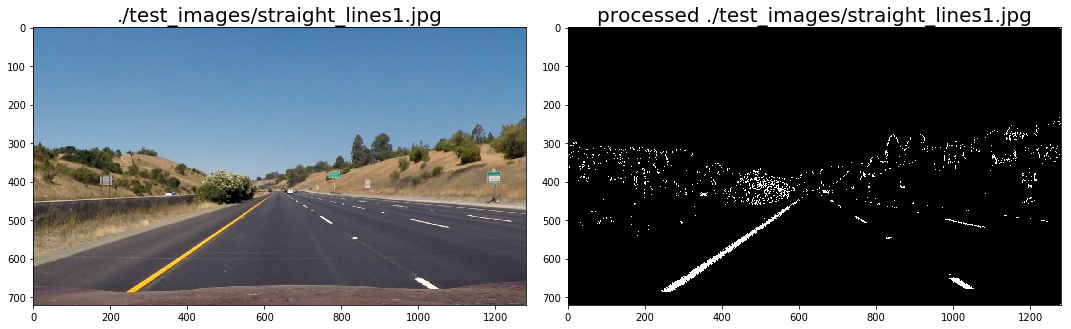

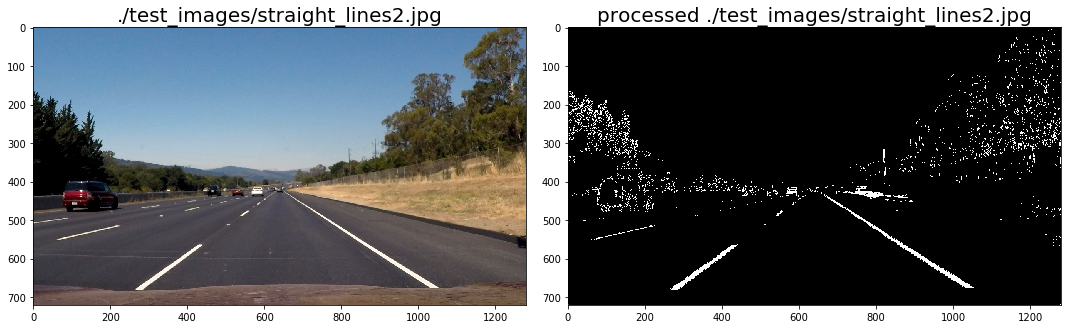

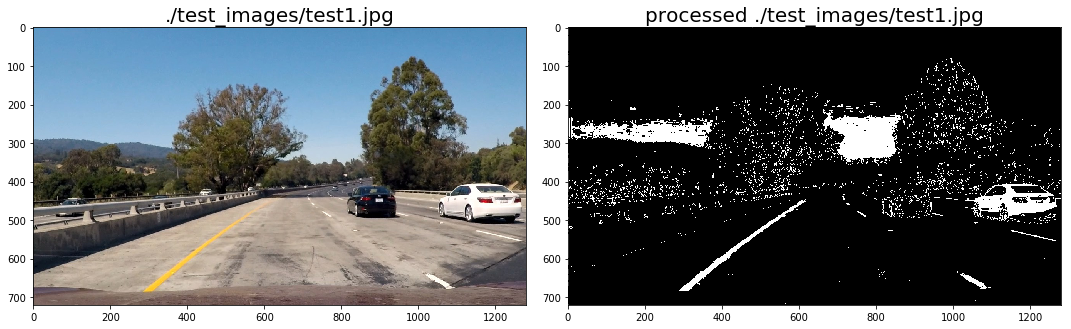

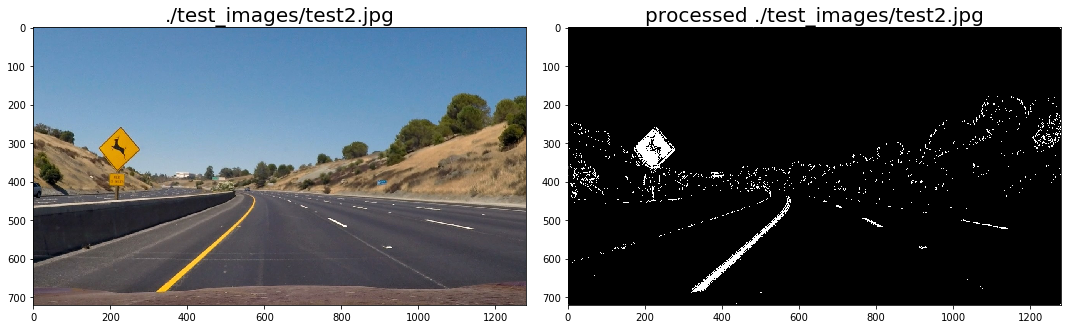

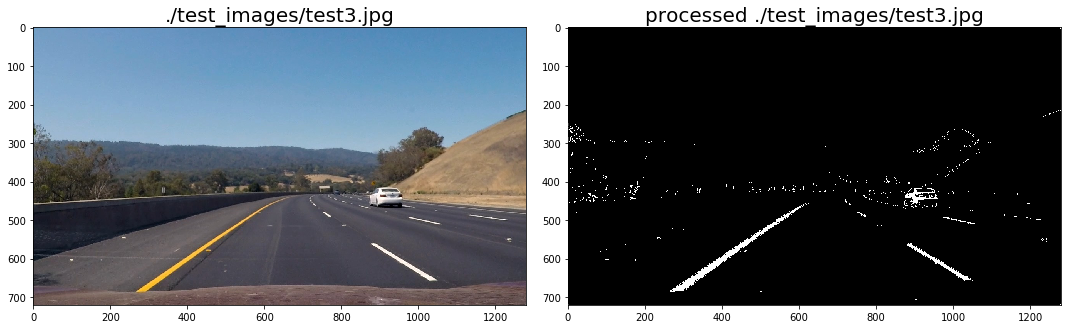

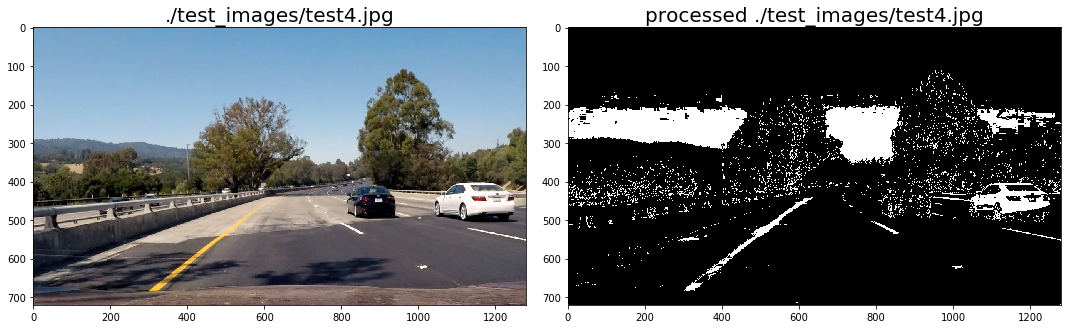

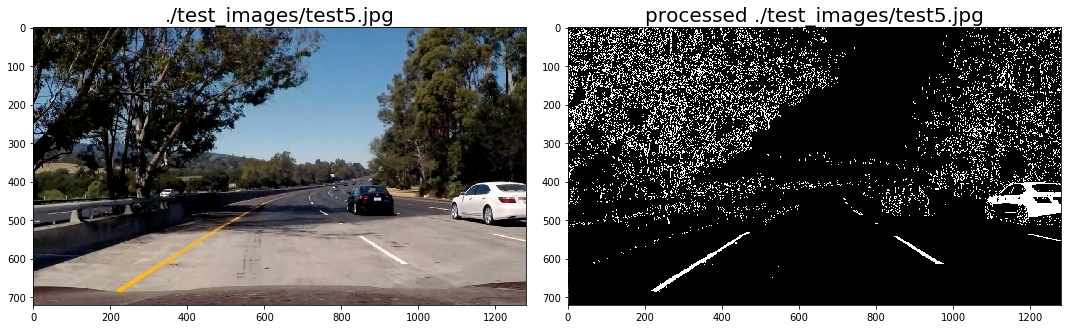

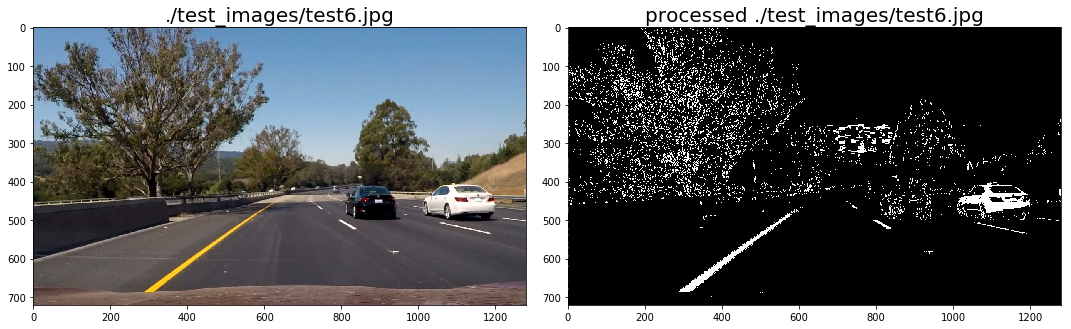

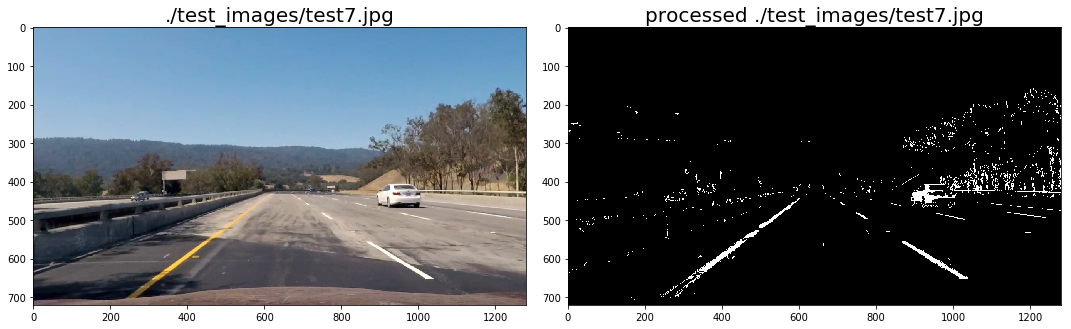

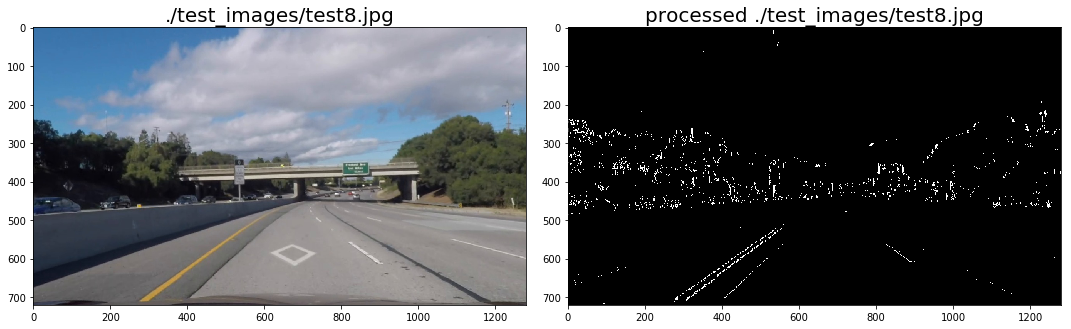

In [57]:
#Make a list of example images
images = glob.glob('./test_images/*.jpg')

for image in images:
    img = mpimg.imread(image)

    show_two_images(img, image, apply_gradient_and_threshold(img), "processed {0}".format(image))

### Apply a perspective transform to rectify binary image ("birds-eye view").

In [58]:
# Helper function to draw polygon by points
def draw_polygon(img, points, color=[255, 0, 0], thickness=5):
    points = np.append(points, [points[0]], axis=0)
    for i in range(points.shape[0]  - 1):
        cv2.line(img, tuple(points[i]), tuple(points[i+1]), color, thickness)


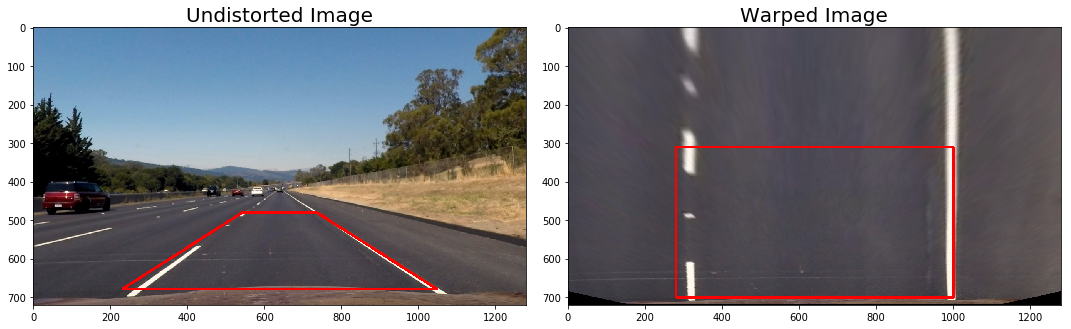

In [59]:
#Compute direct and inverse perspective transforms
src = np.float32([[232, 678], [543, 480], [737, 480], [1048, 678]])
dst = np.float32([[280, 700], [280, 310], [1000, 310], [1000, 700]])

M = cv2.getPerspectiveTransform(src, dst) 
Minv = cv2.getPerspectiveTransform(dst, src)

#function to warp image
def warp_image(img, M):
    shape = img.shape[0:2][::-1]
    return cv2.warpPerspective(img, M, shape, flags=cv2.INTER_LINEAR)


img = undistort_image(mpimg.imread('test_images/straight_lines2.jpg'))
warped = warp_image(img, M)
draw_polygon(img, src)
draw_polygon(warped, dst)
show_two_images(img, "Undistorted Image", warped, "Warped Image")

### Detect lane pixels and fit to find the lane boundary.

In [60]:
def find_lane_lines(binary_warped, nwindows=9, margin=100, minpix=50, debug=False):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = None
    if debug:
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows
    window_height = np.int(binary_warped.shape[0] / nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        if debug:
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 5) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 5) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    if debug:
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit, out_img

(720, 0)

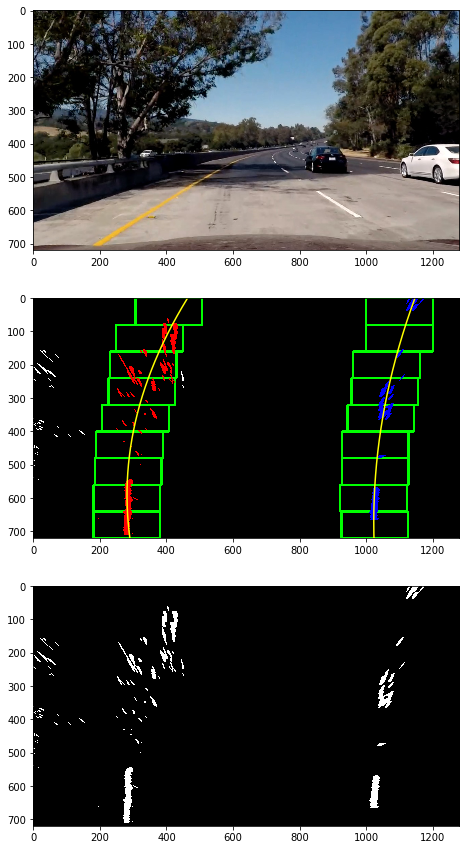

In [66]:
undist = undistort_image(mpimg.imread('test_images/test5.jpg'))
binary = apply_gradient_and_threshold(undist)
binary_warped = warp_image(binary, M)

left_fit, right_fit, out_img = find_lane_lines(binary_warped, debug=True)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

plt.figure(figsize=(10,15))
plt.subplot(3,1,1)
plt.imshow(undist)
plt.subplot(3,1,3)
plt.imshow(binary_warped, cmap='gray')
plt.subplot(3,1,2)
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [67]:
def find_lane_lines_fast(binary_warped, left_fit_prev, right_fit_prev, debug=False):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] - margin)) & 
                      (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] - margin)) & 
                       (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit_new, right_fit_new = (None, None)
    if len(leftx) != 0:
        # Fit a second order polynomial to each
        left_fit_new = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit_new = np.polyfit(righty, rightx, 2)
    
    debug_image = None
    if debug:
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit_new[0]*ploty**2 + left_fit_new[1]*ploty + left_fit_new[2]
        right_fitx = right_fit_new[0]*ploty**2 + right_fit_new[1]*ploty + right_fit_new[2]

        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 10, 10]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [10, 10, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        debug_image = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)        
    
    return left_fit_new, right_fit_new, debug_image

(720, 0)

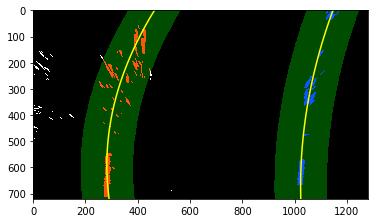

In [68]:
left_fit, right_fit, debug_image = find_lane_lines_fast(binary_warped, left_fit, right_fit, True)

plt.imshow(debug_image)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [69]:
def lane_curvature(fit_line, y_eval):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Generate x and y values for plotting
    points_y = np.linspace(0, y_eval - 1, y_eval)
    points_x = fit_line[0] * points_y ** 2 + fit_line[1] * ploty + fit_line[2]

    fit_line_new = np.polyfit(points_y * ym_per_pix, points_x * xm_per_pix, 2)
    curvature = ((1 + (2 * fit_line_new[0] * y_eval * ym_per_pix + fit_line_new[1])**2)**1.5) / np.absolute(2*fit_line_new[0])
    return curvature

print(lane_curvature(left_fit, binary_warped.shape[0]))
print(lane_curvature(right_fit, binary_warped.shape[0]))
curvature = min(lane_curvature(left_fit, binary_warped.shape[0]),
                lane_curvature(right_fit, binary_warped.shape[0]))

330.691031409
600.231228086


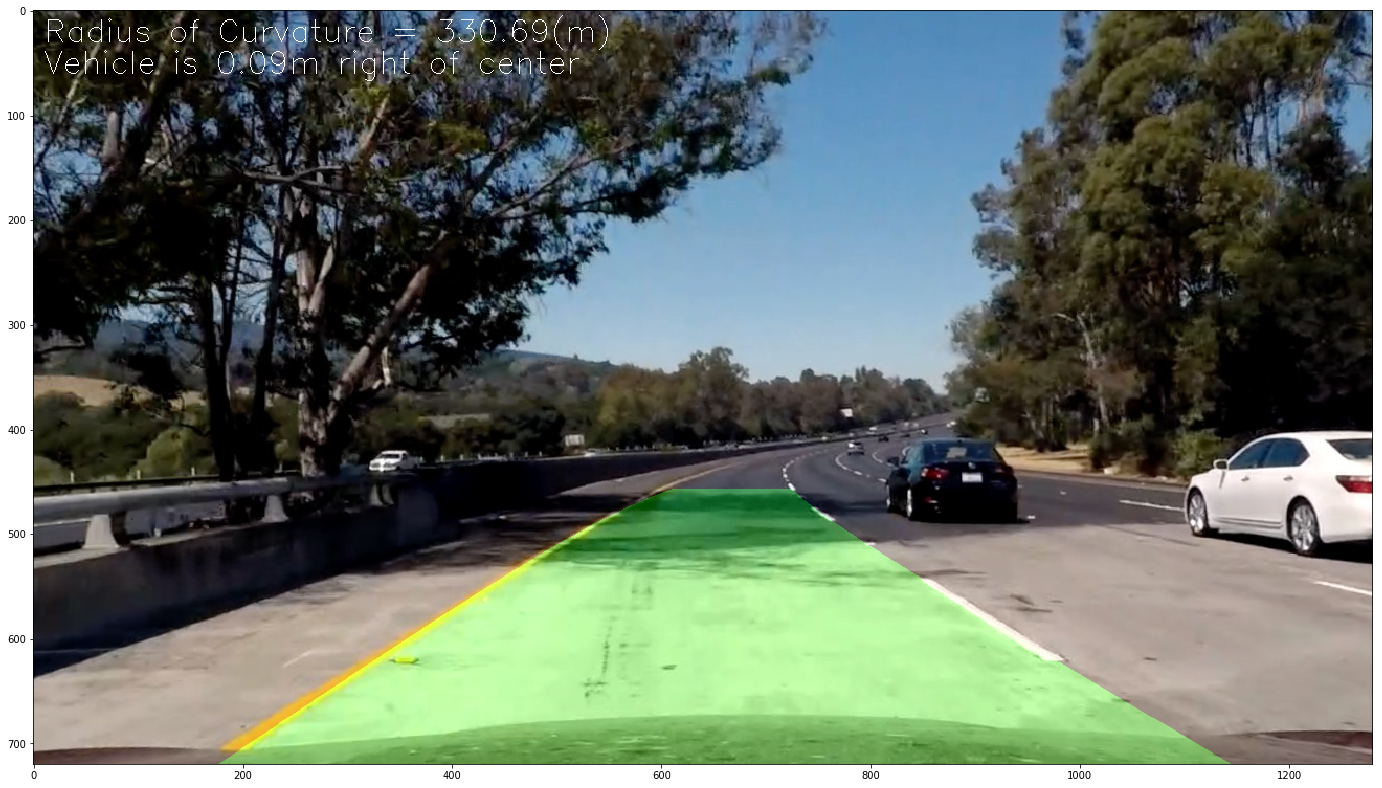

In [70]:
%matplotlib inline

# This function fill polyline bounded by lane lines as well as add information about
# curvature and vehicle position
def draw_lanes_info(image, left_fit, right_fit, curvature):
    # Create an image to draw the lines on
    color_warp = np.zeros_like(image).astype(np.uint8)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, image.shape[0] - 1, image.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2] 

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = warp_image(color_warp, Minv)
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    text = "Radius of Curvature = {0:.2f}(m)".format(curvature)
    fontFace = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result, text, (10, 30), fontFace, 1, (255,255,255))
    vehicle_positioin = (left_fitx[-1] + right_fitx[-1]) / 2.0
    vehicle_offset = vehicle_positioin - image.shape[1] / 2.0
    vehicle_offset *= 3.7/700
    text = "Vehicle is {0:.2f}m {1} of center".format(abs(vehicle_offset), "right" if vehicle_offset > 0 else "left")
    cv2.putText(result, text, (10, 60), fontFace, 1, (255,255,255))
    return result

    
#Test final_drawing
plt.figure(figsize=(24,18))
plt.imshow(draw_lanes_info(undist, left_fit, right_fit, curvature))

### Define helper classes

In [71]:
# Define a class to receive the characteristics of each line detection
class Line():
    # most of the fields was not used.
    # kept them just in case if algorithm will be modified
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        #self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        #self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        #self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        #self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        #self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        #self.allx = None  
        #y values for detected line pixels
        #self.ally = None
        
    def add_sample(self, fit):
        self.detected = False
        if fit is not None:
            self.detected = True
            # if we have history then check that new fit correspond to history
            if self.best_fit is not None:
                diffs = abs(fit-self.best_fit)
                if (diffs[0] > 0.0025 or diffs[1] > 1.0 or diffs[2] > 100.) and len(self.current_fit) > 0:
                    self.detected = False

        # if new sample is good, then append it
        if self.detected == True:
            self.current_fit.append(fit)
            # keep only limited number of samples
            if len(self.current_fit) > 5:
                self.current_fit = self.current_fit[1:]

        # if sample is bad, then forget the oldest sample
        if self.detected == False:
            if len(self.current_fit) > 0:
                # throw out oldest fit
                self.current_fit = self.current_fit[1:]

        # recalculate best fit only if we have samples
        # othewise, old best fit will be kept
        if len(self.current_fit) > 0:
            self.best_fit = np.average(self.current_fit, axis=0)

In [72]:
class LanesHandler:
    def __init__(self):
        self.left_lane = Line()
        self.right_lane = Line()
        # keep some statistics for debug
        self.fast_lanes_finder_counter = 0
        self.lanes_finder_counter = 0
        
    def handle_image(self, image):
        undist = undistort_image(image)
        binary = apply_gradient_and_threshold(undist)
        binary_warped = warp_image(binary, M)
        
        if (not self.left_lane.detected or
            not self.right_lane.detected):
            left_fit, right_fit, _ = find_lane_lines(binary_warped, debug=False)
            self.lanes_finder_counter += 1
        else:
            left_fit, right_fit, _ = find_lane_lines_fast(binary_warped,
                                                          self.left_lane.best_fit,
                                                          self.right_lane.best_fit,
                                                          debug=False)
            
            self.fast_lanes_finder_counter += 1

        
        self.left_lane.add_sample(left_fit)
        self.right_lane.add_sample(right_fit)

        curvature = min(lane_curvature(self.left_lane.best_fit, binary_warped.shape[0]),
                        lane_curvature(self.right_lane.best_fit, binary_warped.shape[0]))
        
        result = draw_lanes_info(undist,
                                 self.left_lane.best_fit,
                                 self.right_lane.best_fit,
                                 curvature)
        return result

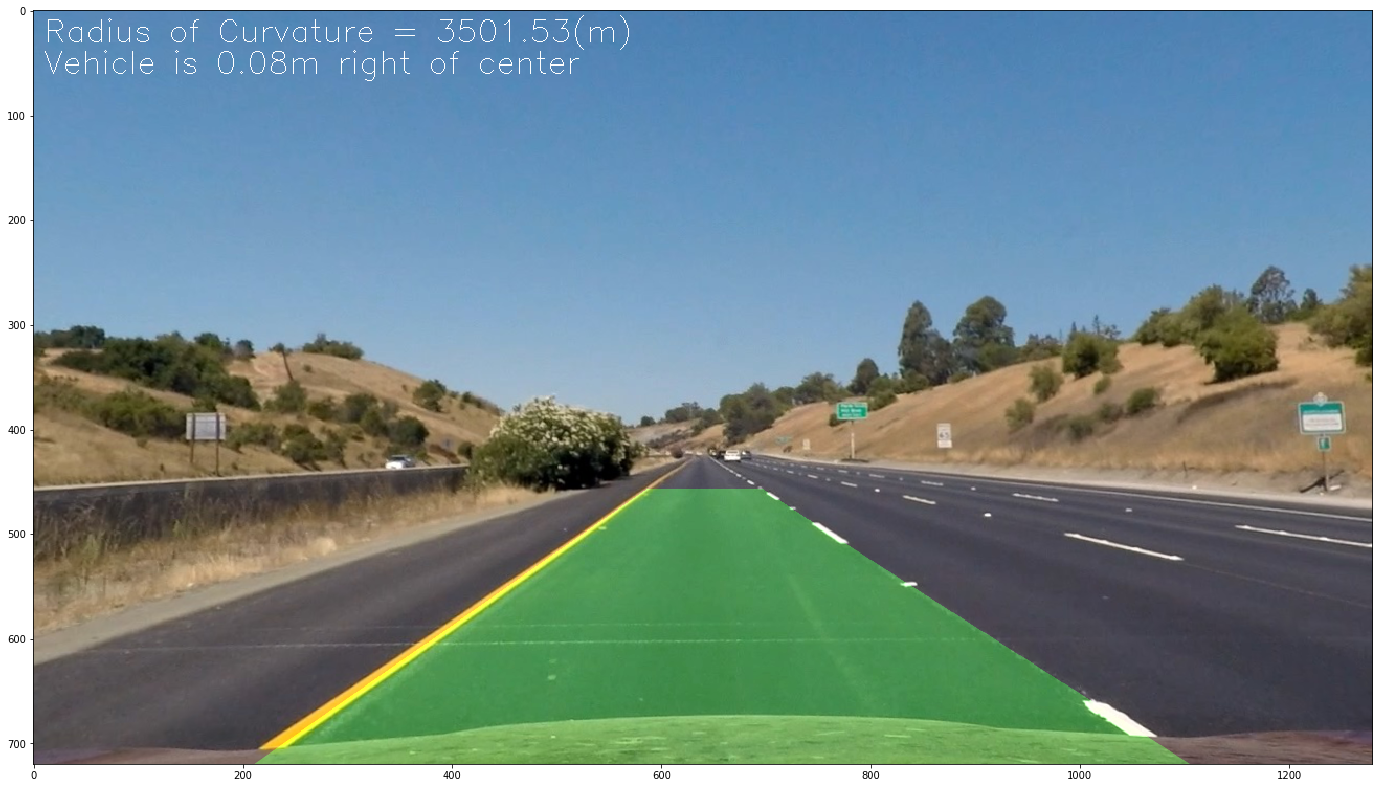

In [73]:
#Test full pipeline
lanes_handler = LanesHandler()
image = mpimg.imread('test_images/straight_lines1.jpg')
plt.figure(figsize=(24,18))
plt.imshow(lanes_handler.handle_image(image), cmap='gray')

### Process video

In [44]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

lanes_handler = LanesHandler()
white_output = 'test_videos_output/project_video.mp4'
#clip1 = VideoFileClip("project_video.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(lanes_handler.handle_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4


100%|█████████▉| 1260/1261 [02:40<00:00,  8.09it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video.mp4 

CPU times: user 3min 18s, sys: 37.8 s, total: 3min 55s
Wall time: 2min 41s


In [ ]:
print(lanes_handler.fast_lanes_finder_counter)
print(lanes_handler.lanes_finder_counter)

In [494]:
#white_output = 'test_videos_output/harder_challenge_video.mp4'
#clip1 = VideoFileClip("harder_challenge_video.mp4")
#white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
#%time white_clip.write_videofile(white_output, audio=False)

In [493]:
#white_output = 'test_videos_output/challenge_video.mp4'
#clip1 = VideoFileClip("challenge_video.mp4")
#white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
#%time white_clip.write_videofile(white_output, audio=False)